## Simply to plot a time series with peaks and other informations

Detected 481 time points.
Figure saved to: /home/phd2/Scrivania/CorsoRepo/cellPIV/paper_figures/random_traces_peaks_annotated.png


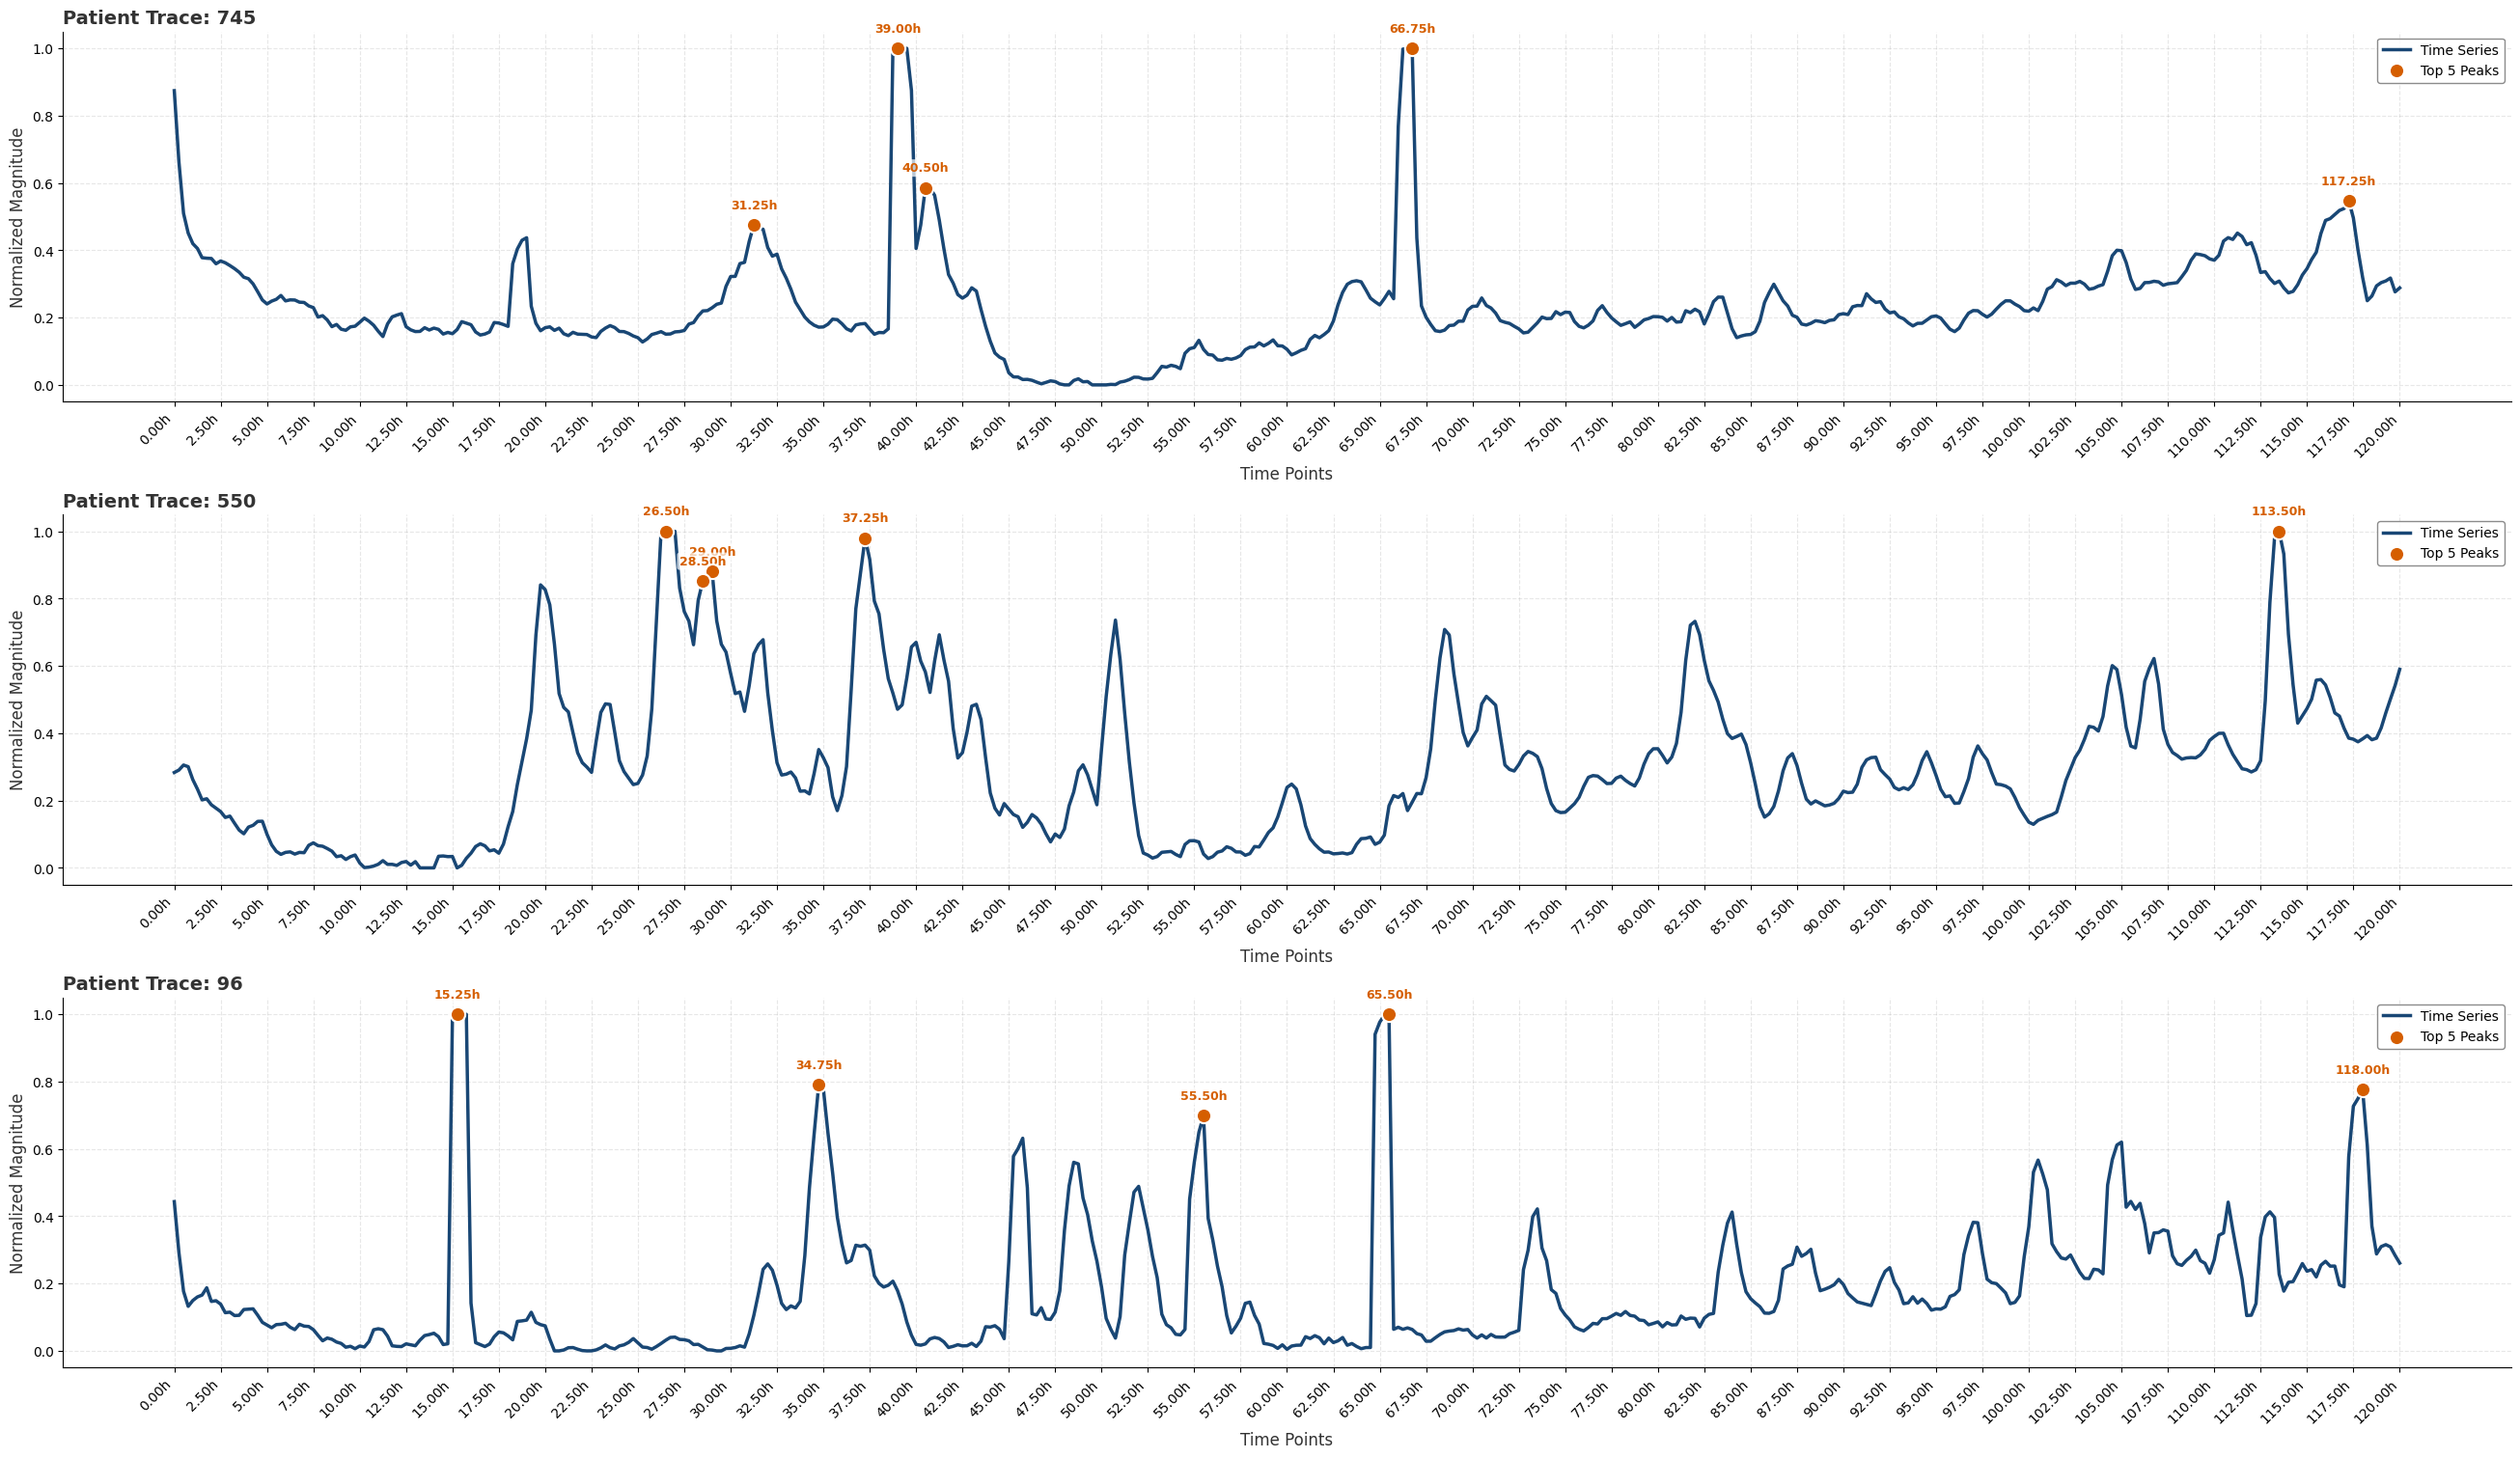

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import os

# --- Configuration ---
file_path = "/home/phd2/Scrivania/CorsoRepo/cellPIV/datasets/Farneback/subsets/Normalized_sum_mean_mag_5Days_train.csv"
SAVE_IMGS = True
save_dir = "/home/phd2/Scrivania/CorsoRepo/cellPIV/paper_figures"
n_plots = 3  # Number of random lines to plot

# Colorblind-friendly palette
COLOR_LINE = '#003366'  # Blue Navy
COLOR_PEAK = '#D55E00'  # Vermilion/Orange
COLOR_TEXT = '#333333'  # Dark Gray for text

# Set a "fancier" global style
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--'
})

# --- Load Data ---
try:
    df = pd.read_csv(file_path, sep=None, engine='python')
except Exception as e:
    print(f"Error reading file: {e}")
    df = pd.read_csv(file_path)

# --- Preprocessing ---
time_cols = [c for c in df.columns if c.endswith('h') and c[0].isdigit()]

if not time_cols:
    raise ValueError("Could not automatically detect time columns (format '0.00h').")

print(f"Detected {len(time_cols)} time points.")

# Select random samples
try:
    sample_df = df.sample(n=n_plots)
except ValueError:
    sample_df = df

# --- Plotting ---
# 1. WIDER: Increased width to 18 and height per plot to 5
fig, axes = plt.subplots(len(sample_df), 1, figsize=(26, 5 * len(sample_df)), constrained_layout=True)

if len(sample_df) == 1:
    axes = [axes]

for ax, (idx, row) in zip(axes, sample_df.iterrows()):
    y = pd.to_numeric(row[time_cols], errors='coerce').values
    x = np.arange(len(y))
    
    # Find peaks
    peaks, _ = find_peaks(y)
    
    # Filter Top 5 Peaks
    if len(peaks) > 0:
        peak_heights = y[peaks]
        top_peak_indices_in_peak_array = np.argsort(peak_heights)[::-1][:5]
        top_peaks = peaks[top_peak_indices_in_peak_array]
    else:
        top_peaks = []

    # Plot Line
    ax.plot(x, y, color=COLOR_LINE, linewidth=2.5, label='Time Series', alpha=0.9)
    
    # Highlight Peaks and 3. ANNOTATE
    if len(top_peaks) > 0:
        ax.scatter(top_peaks, y[top_peaks], color=COLOR_PEAK, s=120, zorder=5, marker='o', edgecolors='white', linewidth=1.5, label='Top 5 Peaks')
        
        for peak_idx in top_peaks:
            # Get the specific time string (e.g., "1.25h")
            time_label = time_cols[peak_idx]
            peak_val = y[peak_idx]
            
            # Annotate near the peak
            ax.annotate(
                text=time_label,
                xy=(peak_idx, peak_val),
                xytext=(0, 10),  # Offset: 0 points horizontal, 10 points vertical
                textcoords='offset points',
                ha='center', 
                va='bottom',
                fontsize=9,
                color=COLOR_PEAK,
                fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7, ec="none") # Small background for readability
            )

    # 2. FANCIER: Clean titles, better ticks
    patient_id = row['patient_id'] if 'patient_id' in df.columns else f"Row {idx}"
    ax.set_title(f"Patient Trace: {patient_id}", loc='left', color=COLOR_TEXT, fontweight='bold')
    ax.set_ylabel("Normalized Magnitude", color=COLOR_TEXT)
    
    # X-ticks logic
    n_steps = 49
    if len(x) > n_steps:
        step = len(x) // (n_steps-1)
        xticks = list(range(0, len(x), step))
        if xticks[-1] != len(x) - 1:
            xticks.append(len(x) - 1)
        ax.set_xticks(xticks)
        ax.set_xticklabels([time_cols[i] for i in xticks], rotation=45, ha='right')
    else:
        ax.set_xticks(x)    
        ax.set_xticklabels(time_cols, rotation=45, ha='right')
        
    ax.set_xlabel("Time Points", color=COLOR_TEXT)
    ax.legend(loc='upper right', frameon=True, framealpha=0.9, edgecolor='gray')

# --- Saving ---
if not os.path.exists(save_dir) and SAVE_IMGS:
    try:
        os.makedirs(save_dir)
        print(f"Created directory: {save_dir}")
    except OSError as e:
        print(f"Could not create directory {save_dir}. Error: {e}")

save_path = os.path.join(save_dir, "random_traces_peaks_annotated.png")
plt.savefig(save_path, dpi=500, bbox_inches='tight')

print(f"Figure saved to: {save_path}")
plt.show()